# Plot the Results
Plot the ternaries and binaries predicted using machine learning

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd
import ternary
import os

Variables to change

In [2]:
figure_width = 89 / 25.4
figure_height = figure_width * 0.7

## Plot the Ti-O Binary
The goal is to see how well the convex hull of the ML models agrees with reality

### Read the data

In [3]:
dft_data = pd.read_csv(os.path.join('datasets', 'Ti-O_test_set-fractions.csv'))

In [4]:
rf_fractions_data = pd.read_csv(os.path.join('model-outputs', 'RF_Ti-O_search-space-fractions.csv'))

### Make the plots

In [5]:
dft_TiO = dft_data.query('X_Ti + X_O > 0.99')

In [6]:
rf_fractions_TiO = rf_fractions_data.query('X_Ti + X_O > 0.99 and X_Ti > 0 and X_O > 0')

In [7]:
def get_hull(data):
    """Get the plot points for the Ti-O binary convex hull"""
    # Generate the points
    hull_points = data[['X_Ti', 'delta_e']].query('delta_e < 0').values.tolist()
    original_len = len(hull_points)
    hull_points.extend([[0,0],[1,0]])
    hull_points = np.array(hull_points)
    
    # Compute the convex hull
    hull = ConvexHull(hull_points)
    
    # Return the coordinate of the plot
    plot_points = []
    for simplex in hull.simplices:
        if all([x >= original_len for x in simplex]):
            continue # This is the [0,1] point
        plot_points.append([hull_points[simplex, 0], hull_points[simplex, 1]])
    return plot_points

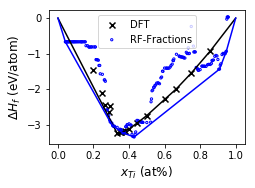

In [8]:
fig, ax = plt.subplots()

# Plot the DFT convex hull
ax.scatter(dft_TiO['X_Ti'], dft_TiO['delta_e'], marker='x', color='k', label='DFT')
for x, y in get_hull(dft_TiO):
    ax.plot(x, y, 'k')

# Plot the RF convex hull
ax.scatter(rf_fractions_TiO['X_Ti'], rf_fractions_TiO['delta_e'], s=5,
           marker='o', color='b', facecolor='none', label='RF-Fractions')
for x, y in get_hull(rf_fractions_TiO):
    ax.plot(x, y, 'b')
    
ax.legend(fontsize=10)

ax.set_xlabel('$x_{Ti}$ (at%)', fontsize=12)
ax.set_ylabel('$\Delta H_f$ (eV/atom)', fontsize=12)

fig.set_size_inches(figure_width, figure_height)

fig.savefig(os.path.join('figures', 'TiO-binary.png'), dpi=320)
fig.savefig(os.path.join('figures', 'TiO-binary.pdf'))

## Make a ternary plot
Plot one of the ternaries in the Na-Fe-Mn-O leave-out test

### Read the data

In [9]:
dft_data = pd.read_csv(os.path.join('datasets', 'NaFeMnO_test_set-fractions.csv'))

In [10]:
rf_fractions_data = pd.read_csv(os.path.join('model-outputs', 'RF_NaFeMnO_search-space-fractions.csv'))

### Make the plot

In [11]:
dft_NaMnO = dft_data[np.isclose(dft_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)]

In [12]:
rf_fractions_NaMnO = rf_fractions_data[np.isclose(rf_fractions_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)].query(
    ' and '.join(['X_%s > 0'%x for x in ['Mn', 'Na', 'O']]))

In [13]:
def get_hull(data):
    """Get the plot points for the Ti-O binary convex hull"""
    # Generate the points
    hull_points = data[['X_Na', 'X_Mn', 'delta_e']].query('delta_e < 0').values.tolist()
    original_len = len(hull_points)
    hull_points.extend([[0,0,0],[0,1,0],[1,0,0]])
    hull_points = np.array(hull_points)
    
    # Compute the convex hull
    hull = ConvexHull(hull_points)
    
    # Return the coordinate of the plot
    plot_points = []
    for simplex in hull.simplices:
        if all([x >= original_len for x in simplex]):
            continue # This is the [0,1] point
        x = np.append(hull_points[simplex, 0], hull_points[simplex[0], 0])
        y = np.append(hull_points[simplex, 1], hull_points[simplex[0], 1])
        plot_points.append([x, y])
        
    return plot_points

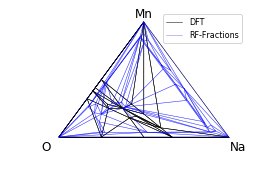

In [14]:
fig, ax = plt.subplots()

fig, tax = ternary.figure(scale=1, ax=ax)

# Plot the DFT convex hull
for x, y in get_hull(dft_NaMnO):
    xs, ys = ternary.helpers.project_sequence(zip(x,y))
    dft_h, = ax.plot(xs, ys, 'k', lw=0.5)

# Plot the RF convex hull
for x, y in get_hull(rf_fractions_NaMnO):
    xs, ys = ternary.helpers.project_sequence(zip(x,y))
    rf_f_h, = ax.plot(xs, ys, 'b', alpha=0.5, lw=0.5)

# Make it pretty
plt.axis('off')
ax.set_xlim([-0.05, 1.10])
ax.set_ylim([-0.05, 1.10 * 3 ** 0.5 / 2])
ax.text(1.10, -.10, 'Na', ha='right', fontsize=12) # 1st elem
ax.text(.50, .90, 'Mn', ha='center', fontsize=12) # 2nd elem
ax.text(-.10, -.10, 'O', ha='left', fontsize=12) # 3rd elem

ax.legend([dft_h, rf_f_h], ['DFT', 'RF-Fractions'], fontsize=8)

ax.set_xlabel('$x_{Ti}$ (at%)', fontsize=12)
ax.set_ylabel('$\Delta H_f$ (eV/atom)', fontsize=12)

fig.set_size_inches(figure_width, figure_width * 0.7)

fig.savefig(os.path.join('figures', 'NaMnO-ternary.png'), dpi=320)
fig.savefig(os.path.join('figures', 'NaMnO-ternary.pdf'))